# batram examples (WIP)

This notebook is work in progress (WIP)

In [1]:
# Keep this cell while WIP
%load_ext autoreload
%autoreload 2

## Getting Started with Transport Maps

This is our first example getting started with transport maps. It shows how to
fit a transport map to a univariate spatial field, evaluate the fit, and generate
new samples emulating the training data. This is a simple demonstration of the
method published in [1] on a small dataset.

The notebook is separated into the following parts:

- Data loading and visualization
- Data preprocessing
- Fitting a transport map with default optimization settings
- Fitting a transport map with custom optimizers
- Evaluating the fit (checking the optimization)
- Sampling new data
- Scoring new data

References

[1] Katzfuss and Schäfer (2023, JASA). https://doi.org/10.1080/01621459.2023.2197158

In [2]:
# Packages for data loading
import pathlib
import pickle

# Packages for working with array data and tensors
import numpy as np
import matplotlib.pyplot as plt
import torch

# Packages for building transport maps
import veccs.orderings
from batram.legmods import Data, SimpleTM

/home/danjd/projects/transport_maps/batram/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# after the imports set a seed for reproducibility
# anyhow, the results will be different on different machines
# cf. https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(0)
torch.manual_seed(0)

### Data Loading and Inspection

Our model assumes we are loading datasets of the following structure:
- An $N \times d$ array of spatial locations indexing the dataset
- An $n \times N$ array of observations at the $N$ indexed locations

Below we load a test dataset. The data consist of 200 replications of a
spatial field on a 30 x 30 grid over the unit square; i.e., there are $n=200$
samples of a process defined on $(0, 1)^2$ with 30 evenly spaced points in each
dimension.

In [4]:
# Load data and print dimensions
data_fp = pathlib.Path("../tests/data/simNR900.pkl")
with open(data_fp, "rb") as fh:
    data_pkl: dict[str, np.ndarray] = pickle.load(fh)

locs = data_pkl["locations"]
obs = torch.as_tensor(data_pkl["observations"])

# undo the max-min ordering
ord = np.lexsort((locs[:, 1], locs[:, 0]))
locs = locs[ord]
obs = obs[:, ord]

print(f"Locations array dimension: {locs.shape}")
print(f"Observations array dimension: {obs.shape}")

Locations array dimension: (900, 2)
Observations array dimension: torch.Size([200, 900])


To get an idea of what the data look like, we plot the first 50 spatial fields.

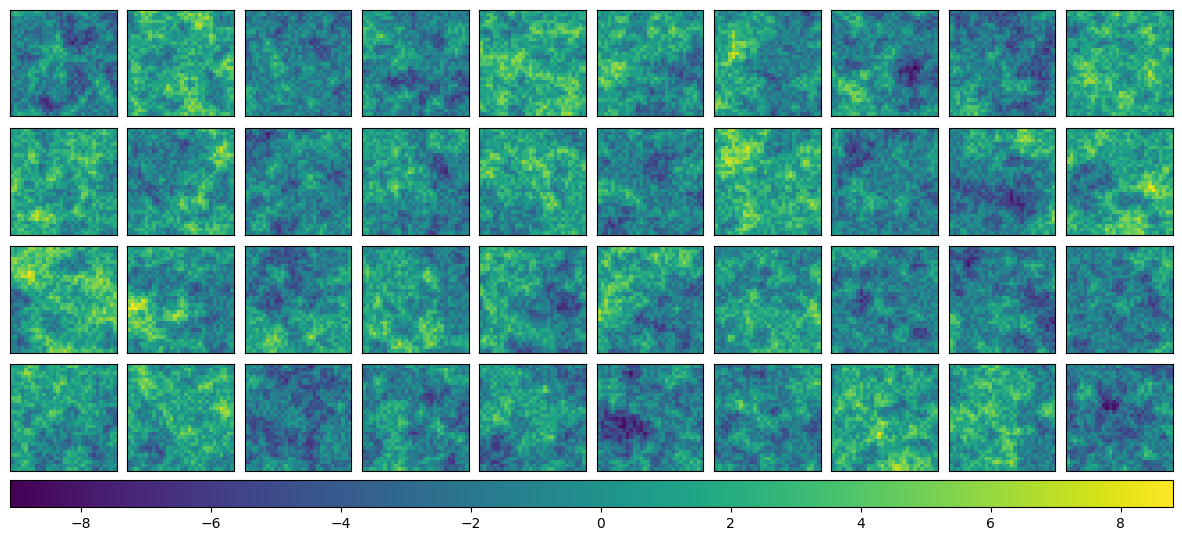

In [5]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = obs[:40].min(), obs[:40].max()
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs[i].reshape(30, 30), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Data Preprocessing and Map Initialization

Our models assume the data have been pixel-wise centered and an ordering of the
data has been computed. We also require nearest neighbor information to fit the
model. The centering is easy to do using numpy or pytorch arrays, and the `veccs`
package provides the required functionality for the remaining steps. The next
code block demonstrates the typical preprocessing steps, then stores the
transformed data in a `Data` container.

In [6]:
# The loaded data contained 200 replicate spatial fields (200 samples, 900 locs).
# We will subset the data to use the first 10 samples and the entire spatial
# field.
obs = obs[:10, :]

# Pixel-wise data centering. NB `obs` is a torch tensor.
obs = obs - obs.mean(dim=0, keepdim=True)

# Maximin ordering of the locations using the `veccs` package.
# Note, the locations array is reordered over its first dimension, whereas the
# observations are reordered over the last dimension.
order = veccs.orderings.maxmin_cpp(locs)
locs = locs[order, ...]
obs = obs[..., order]

# Finding nearest neighbors using the `veccs` package.
# The computation time of the model scales as a function of the condition set
# size. We recommend restricting this to be no larger than 30 neighbors.
largest_conditioning_set = 30
nn = veccs.orderings.find_nns_l2(locs, largest_conditioning_set)

# Create a `Data` object for use with the `SimpleTM` model.
# All objects passed to this class must be torch tensors, so we type convert
# the numpy arrays in this step.
data = Data.new(torch.as_tensor(locs), obs, torch.as_tensor(nn))

With data preprocessed and stored in the appropriate container, we can initialize
a transport map. The `SimpleTM` is a class representing the model. Model
initialization can be done by passing only the `Data` container or with optional
flags. More details about the arguments are provided in comments below.

The `SimpleTM` can be instantiated with parameters (keyword arguments)
- `theta_init`: initial parameter values for the transport map
- `linear`: whether to use a linear transport map (the linear map is not currently supported)
- `smooth`: the smoothness parameter $\nu$ in a Matern kernel
- `nug_mult`: a multiplier for the nugget term in the Matern kernel

The instantiation below shows the default values for each of these. The `theta_init`
parameter would be a `torch.Tensor` with six entries. The initial values are not
so important to fitting models, and these can for the most part be ignored.

The rationale for each of these can be found in Section 3.3 of Katzfuss and Schafer
(2023, JASA; https://doi.org/10.1080/01621459.2023.2197158).

In [7]:
tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)

### Model Optimization

This `tm` object has a built-in fit method with default choices that work well
in most of our experiments. If you want to use different optimization settings,
you can pass your own optimizers, learning rate schedulers, and other arguments
to the `fit` method.

Our default settings are shown next. You could equivalently call
```python
res = tm.fit(nsteps, 0.1, test_data=tm.data, batch_size=128)
```
and obtain the same results as below.

In [8]:
# The `nsteps` argument is always required. When using a user-defined optimizer
# we ignore the initial learning rate. The `batch_size` specifies how to perform
# minibatch gradient descent. The `test_data` argument is optional and is used
# to compute the test loss at each step.
nsteps = 200
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = tm.fit(
    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=128
)

Train Loss: 9350.213, Test Loss: 9350.481: 100%|██████████| 200/200 [00:03<00:00, 51.90it/s]


### Evaluating the Map Fit

The model is fit by minibatched optimization, so some caution should be taken to
verify the model has at least converged before using it for any kind of inference
or sampling. The `fit` method returns a `FitResult` object that contains
information about the optimization. This includes tracking the loss function and
model parameters at each iteration of the optimization. The `FitResult` object
has helper methods to plot the loss function and model parameters over the
course of the optimization. The next cells show how to use these methods.

TODO: State, that the test loss is not the loss over the entire data set if
batching is used but the averge of the losses encountered during an epoch.

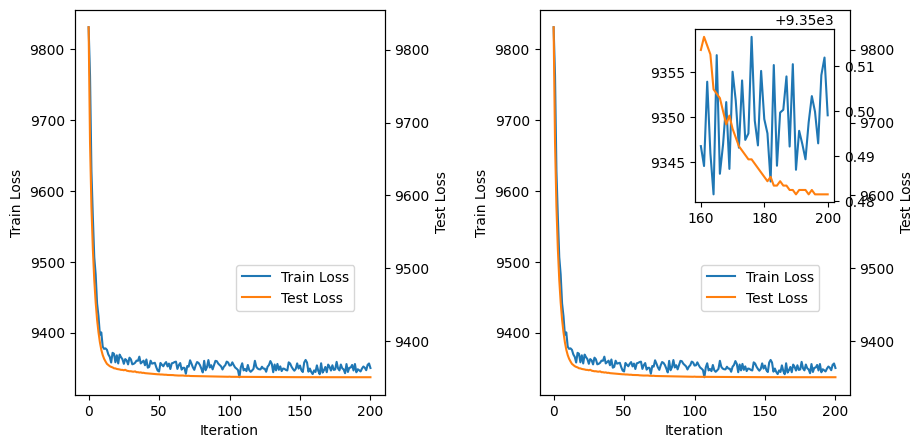

In [9]:
# The `plot_loss` method optionally allows plotting the loss using an inset. The
# inset is useful for visualizing the loss near convergence. It plots the last
# 20% of the loss values when building the inset.
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"wspace": 0.5})
res.plot_loss(axs[0], use_inset=False)
res.plot_loss(axs[1], use_inset=True)
plt.show()

We can inspect traceplots of the model parameters throughout the optimization.
There are few parameters in the model, so they are all coplotted in the same figure.
A good indication, and what we look for in practice, is to see that each parameter
eventually converges. Parameter convergence will look like the green curve below
(`\theta_2`), where the parameter has moved from its initial value and eventually
settles on a stable value. Ideally every parameter will converge. If that is not
the case, the optimizer should be rerun for a longer period of time, possibly
with arguments to the fit method (including the optimizer and scheduler) adjusted.

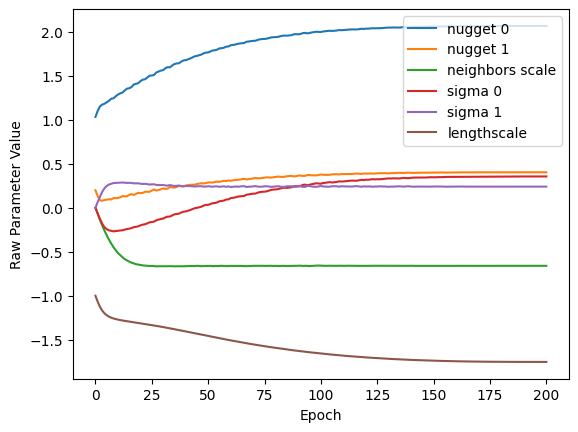

In [10]:
res.plot_params()
plt.show()

A derived value from the parameters above is the number of nearest neighbors to
use in the approximation. Below we derive that number to show how it evolves over
the course of the optimization. As it is derived from the parameters above, it
should eventually stabilize on a constant value. Note the number of neighbors are
bound between 0 and the number of neighbors we constructed in preprocessing
(typically 30).

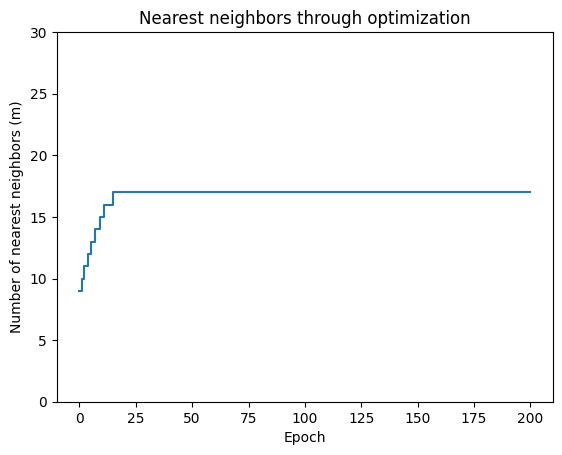

In [11]:
res.plot_neighbors()
plt.show()

### Sampling

Now we show sampling new spatial fields from the fitted map. Currently this
supports drawing one new sample at a time only. To draw `n` new samples, put
this method in a for loop.

In [12]:
# tm.cond_sample() can sample more than one field at a time. The first dimension
# of the returned tensor refers to the number of samples. The remaining
# dimensions are the same as the dimensions of the data.

new_sample = tm.cond_sample()[0, ...]
re_ordered_sample = torch.zeros_like(new_sample)
re_ordered_sample[..., order] = new_sample

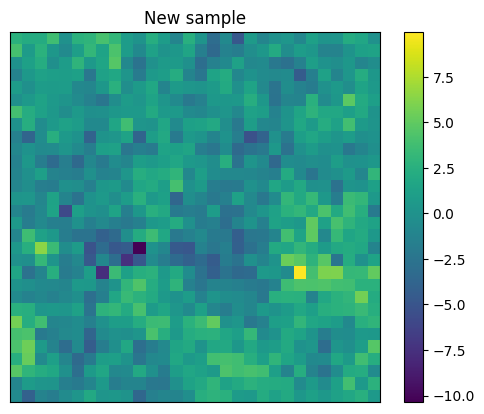

In [13]:
plt.imshow(re_ordered_sample.reshape(30, 30))
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("New sample")
plt.show()

Unlike most samplers, this model can draw samples conditional on partially
observed data. The data must be in the ordering used to fit the model, but this
is the only requirement. We demonstrate below by resampling from the training
data with observations of the first 50 points.

In [14]:
# Resample with a partially observed part of the training data
partial_field = obs[0, :250]

# Drawing the conditional sample
conditional_samples = tm.cond_sample(x_fix=partial_field, num_samples=2)

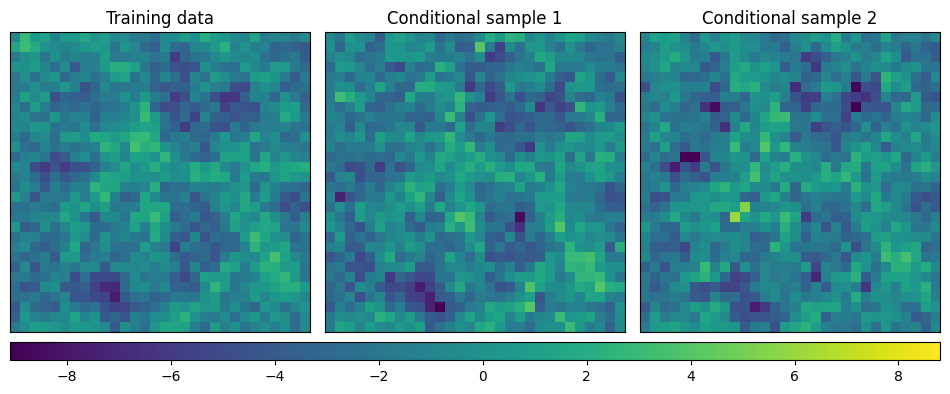

In [15]:
# Compare the resampled field with the training data
gspec = {"wspace": 0.05}
fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=gspec, squeeze=True)

# Plot the training data
ax[0].imshow(obs[0][order.argsort()].reshape(30, 30), vmin=vmin, vmax=vmax)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Training data")

# Plot the conditionally resampled field (sample 1)
im = ax[1].imshow(conditional_samples[0, order.argsort()].reshape(30, 30), vmin=vmin, vmax=vmax)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Conditional sample 1")

# Plot the conditionally resampled field (sample 2)
im = ax[2].imshow(conditional_samples[1, order.argsort()].reshape(30, 30), vmin=vmin, vmax=vmax)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title("Conditional sample 2")

fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Scoring

We can also score observations using the model. This is useful for evaluating if
a new sample or observation is consistent with the training data. The score is
the negative log-likelihood of the observation under the model. The lower the
score, the more consistent the observation is with the training data.

In [16]:
# TODO: Internalize this context into the score function.
# Is there a way to accelerate this code?

with torch.no_grad():
    sample_score = tm.score(new_sample)

print(f"Score of new sample: {sample_score:.2f}")

Score of new sample: -1576.41
